## Section 4: Bayesian Regression
我们已经回答了问题：“我的回应时间是否受到聊天对象而不同”。我们计算了每个独立模型的参数。但是有时候我们想知道其他的因素，比如“星期几”,“当前时间”等对消息回应时间的影响。我们可以使用广义线性模型（GLM）来更好的理解这些因素的影响力。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


### Linear regression reminder
当我们有个$y$从$-\infty$ 到 $\infty$连续取值，我们可以用一个线性回归模型表示它：

$$ y \sim \mathcal{N}(\mu, \sigma)$$
$$ \mu = \beta_0 + \beta_1 X_1 \dots \beta_n X_n$$

我们的$y$值散布在均值为$\mu$，标准差为$\sigma$的高斯分布中。$\mu$的取值通过一个对应的线性方程来描述。

### Link functions
在一些非连续值的事件中，模型对应的变量取值就不能是用$-\infty$到$\infty$表示，这时可以用一个连接函数来转换对应的取值范围。对Poisson分布来说，正统的连接函数是用的log link，这样得到的$\mu$值就是正数。这个想法可以被形式化的表示为：

$$y \sim Poisson(\mu)$$
$$log(\mu) = \beta_0 + \beta_1 X_1 \dots \beta_n X_n$$
$$\mu = e^{(\beta_0 + \beta_1 X_1 \dots \beta_n X_n)}$$

这个模型可以认为是固定效应模型。全部的$\beta$系数是在所有数据中被计算的，而不是在单独的一份数据中分别被计算的。（好比池化和部分池化模型）

### Fixed effects Poisson regression
要在PyMC3中构建一个Poisson回归模型，我们需要对$\mu$使用log link function。在PyMC3中的底层数据模型使用theano，因此我们需要theano包的tensor method `theano.tensor.exp()`。

In [4]:
X = messages[['is_weekend', 'day_of_week', 'message_length', 'num_participants']].values
_, num_X = X.shape

with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sd=100)
    beta_message_length = pm.Normal('beta_message_length', mu=0, sd=100)
    beta_is_weekend = pm.Normal('beta_is_weekend', mu=0, sd=100)
    beta_num_participants = pm.Normal('beta_num_participants', mu=0, sd=100)
    
    mu = tt.exp(intercept +
               beta_message_length*messages.message_length +
               beta_is_weekend*messages.is_weekend +
               beta_num_participants*messages.num_participants)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

         Current function value: 2236.721141
         Iterations: 16
         Function evaluations: 67
         Gradient evaluations: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20500/20500 [1:39:39<00:00,  3.50it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CC56E80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000EE48B00>]], dtype=object)

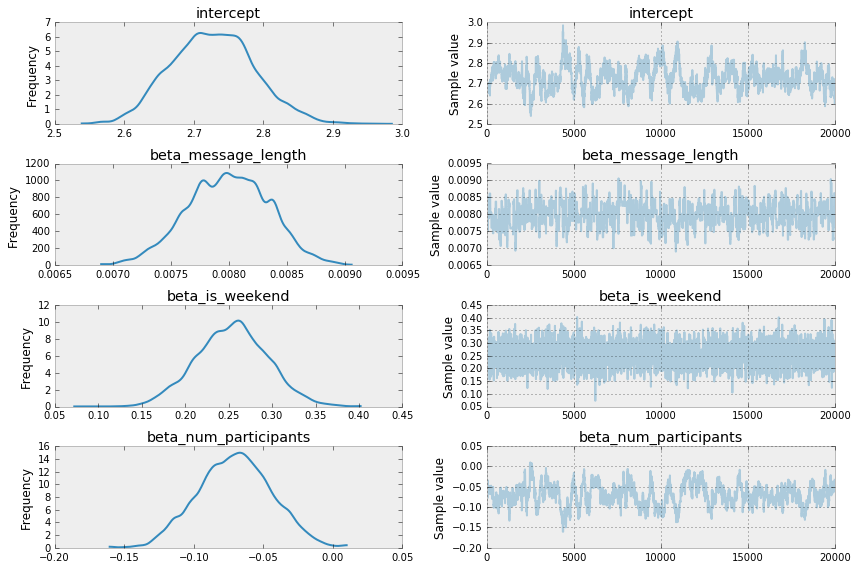

In [5]:
pm.traceplot(trace)

正如上图那样，截距$\beta_0$有一个估计值，范围在2.5到2.9之间，那这意味着什么呢？

不幸的是，要解释Poisson回归的参数意义还需要引入一个简单的线性回归方程($y=\beta x$)。在这个线性回归方程，增加x会同时通过$\beta$影响y值。然而，在Poisson回归，我们需要考虑那个link function。
这个[交叉验证的帖子](http://stats.stackexchange.com/questions/128926/how-to-interpret-parameter-estimates-in-poisson-glm-results)很好的解释了下面的公式。

> For a Poisson model, given a unit change in $x$, the fitted $\hat y$ changes by $\hat y \left( e^\beta - 1 \right)$

这样做的主要原因是，在线性回归方程中，x值的变化和y值的变化是同步的。与简单的线性回归不同，这样做x的单位变化不会导致y同时变化。

### Marginal and pairwise density plots
下面的图展示了边缘密度（在正对角线上的图）和pairwise densities（非对角线上的图）。这个图在理解协变量如何相互作用上非常有用。在上面的例子里，我们可以看到，随着participants数量的增加，截距同时减小（第三行第一列）。

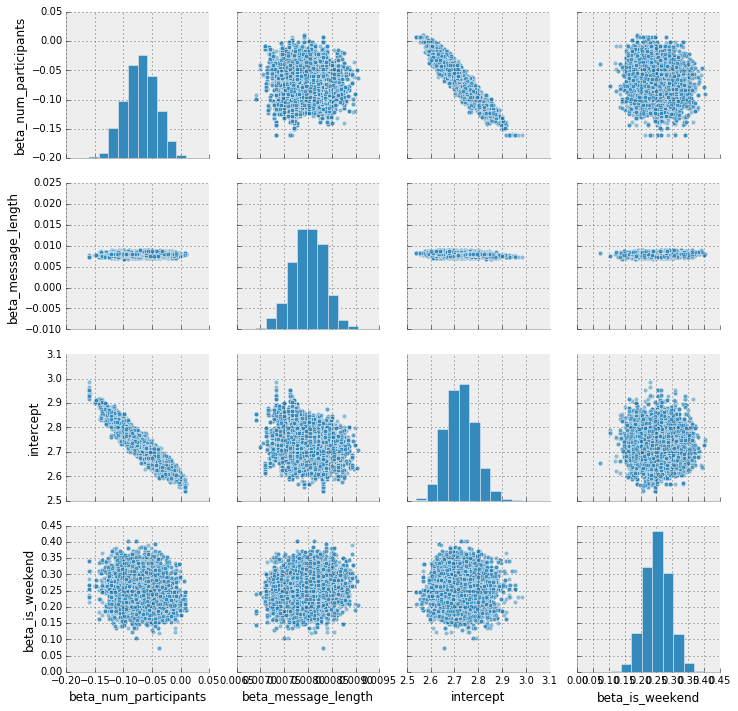

In [6]:
sns.pairplot(pm.trace_to_dataframe(trace[2000:]), plot_kws={'alpha': 0.5})

### Mixed effects poisson regression
我们可以通过引入一个随机的截距参数来扩展上面的模型。这使我们对每个会话可以计算其截距参数值$\beta_0$。对于其他的参数的计算则使用所有会话的数据。对每个person i 和每个消息 j，这个模型可以形式化的表示为：

$$ y_{ji} \sim Poisson(\mu)$$
$$\mu = \beta_{0_i} + \beta_1 x_1 + \dots + \beta_n x_n$$

通过对每个person i引入参数$\beta_0$就产生了一些随机性效果。这使得模型对每个person得到一个不同的截距，同时计算的协变量对所有person的影响。

In [10]:
# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

with pm.Model() as model:
    
    intercept = pm.Normal('intercept', mu=0, sd=100, shape=n_participants)
    slope_message_length = pm.Normal('slope_message_length', mu=0, sd=100)
    slope_is_weekend = pm.Normal('slope_is_weekend', mu=0, sd=100)
    slope_num_participants = pm.Normal('slope_num_participants', mu=0, sd=100)
    
    mu = tt.exp(intercept[participants_idx] + 
               slope_message_length*messages.message_length +
               slope_is_weekend*messages.is_weekend +
               slope_num_participants*messages.num_participants)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

Optimization terminated successfully.
         Current function value: 2216.152969
         Iterations: 47
         Function evaluations: 60
         Gradient evaluations: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20500/20500 [1:40:40<00:00,  3.54it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000014C16AC8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000014D71080>]], dtype=object)

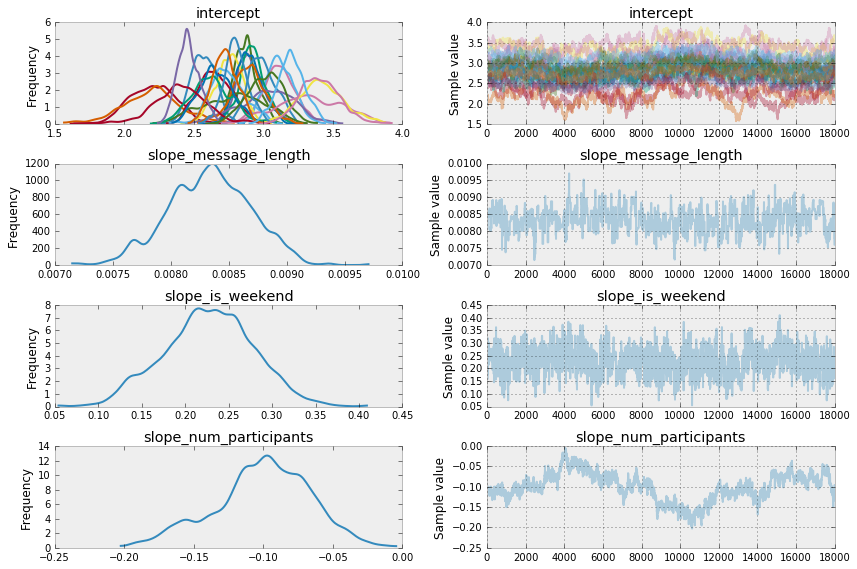

In [11]:
pm.traceplot(trace[2000:])

关于上面图的解释很有意思：
* 每个人都有一个不同的截距响应率（如同第三章的池化和部分池化模型）
* 更长的消息需要更长的时间来回应
* 如果在周末，回复消息的时间更短
* 我会更快地回复有多个人加入的会话

在计算了每个协变量在回复时间上影响后，模型计算出了以下每个会话的$\beta_0$参数值。

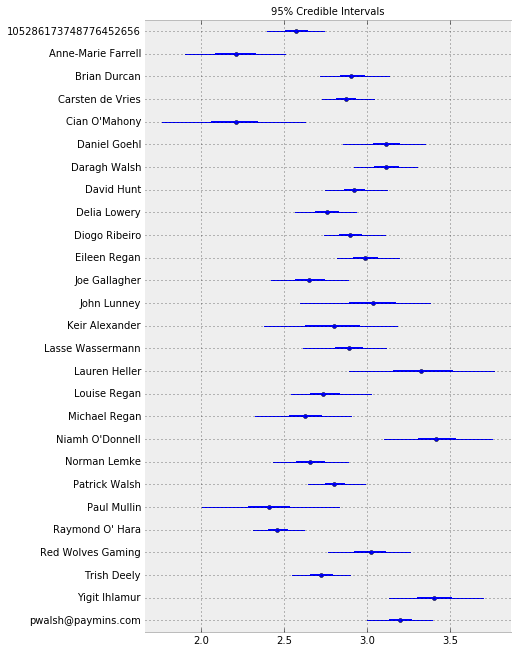

In [14]:
plt.figure(figsize=(8, 10))
pm.forestplot(trace[2000:], varnames=['intercept'], ylabels=participants)

### References

1. [How to interpret parameters of a poisson GLM](http://stats.stackexchange.com/questions/128926/how-to-interpret-parameter-estimates-in-poisson-glm-results)

In [ ]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()